# Gestational Term Classification - Feature Selection Using Extra Trees Classifier

In [1]:
import pandas as pd
import numpy as np

In [2]:
termDf = pd.read_csv('C:/Users/Nefeli/Desktop/biomed_project_data/termDf_bin.csv')

In [3]:
#to_drop=['FHR_I_ffill_haar_shan_entr','FHR_II_ffill_haar_shan_entr']
#termDf= termDf.drop(columns=to_drop).copy()

#Prep dataframe
termDf.replace([np.inf, -np.inf], np.nan, inplace=True)
termDf.dropna(inplace=True)
termDff = termDf.reset_index(drop=True)
termDf.shape

(221, 53)

In [4]:
target = ['Gest_Term']
X = termDf.drop(target, axis=1).copy()
y =termDf[target].copy()

In [5]:
y_labels, counts = np.unique(y['Gest_Term'], return_counts=True)
print(y_labels)
print(counts)

['FT' 'OT']
[118 103]


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['Gest_Term'].ravel())
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping:")
print(label_mapping)

Mapping:
{'FT': 0, 'OT': 1}


#### Feature Selection with ExtraTreesClassifier and SelectFromModel 

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel 

clf = ExtraTreesClassifier(n_estimators=10)
clf = clf.fit(X, y['Gest_Term'].ravel())
#clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_red = model.transform(X)
X_red.shape  

C:\Users\Nefeli\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(221, 22)

In [8]:
# Set feature names explicitly
X_red_named = pd.DataFrame(X_red, columns=X.columns[model.get_support()])

# Print the shape of the transformed data
print("Shape of transformed X:", X_red_named.shape)
X_red_named.columns

Shape of transformed X: (221, 22)


Index(['pH', 'BDecf', 'pCO2', 'BE', 'Apgar5', 'Weight(g)', 'Age',
       'Liq.praecox', 'Induced', 'dbID', 'FHR_I_ffill_sdnn',
       'FHR_I_ffill_rmssd', 'FHR_I_ffill_lf_hf_ratio', 'FHR_I_ffill_haar_mean',
       'FHR_I_ffill_bub_entr', 'FHR_II_ffill_median_nni', 'FHR_II_ffill_sdnn',
       'FHR_II_ffill_lf_hf_ratio', 'FHR_II_ffill_total_power',
       'FHR_II_ffill_vlf', 'FHR_II_ffill_samp_entr', 'diff_nni20'],
      dtype='object')

### Imports For Models:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap 
import xgboost
import matplotlib.pylab as plt

### K-NN

#### Train and Fit

In [10]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded.ravel(), test_size=0.2, random_state=42)

num_nb = 20 # num of neighbors

#train and fit 
knn_clf = KNeighborsClassifier(n_neighbors=num_nb)
fitted_knn=knn_clf.fit(np.ascontiguousarray(X_train), y_train)
y_pred = knn_clf.predict(np.ascontiguousarray(X_test))

# get accruacy
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')


Accuracy: 0.5555555555555556
Confusion Matrix:
[[19  3]
 [17  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.86      0.66        22
           1       0.67      0.26      0.38        23

    accuracy                           0.56        45
   macro avg       0.60      0.56      0.52        45
weighted avg       0.60      0.56      0.51        45



#### ROC 

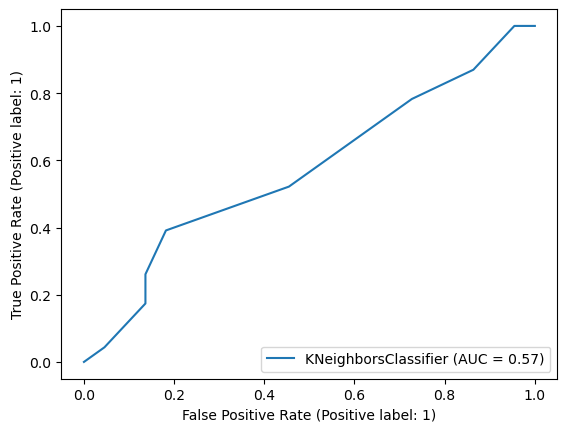

In [11]:
knn_disp = RocCurveDisplay.from_estimator(fitted_knn ,np.ascontiguousarray(X_test), y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [12]:
X_red_named_knn = np.ascontiguousarray(X_red_named)
cross_val_scores_acc = cross_val_score(knn_clf, X_red_named_knn, y_encoded, scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.46666667 0.34090909 0.29545455 0.54545455 0.54545455]
Mean Accuracy:  0.4387878787878788
F1 Score for all folds:  [0.63636364 0.12121212 0.27906977 0.         0.        ]
Mean F1 Score:  0.20732910500352358


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision for all folds:  [0.46666667 0.16666667 0.27272727 0.         0.        ]
Mean Precision:  0.1812121212121212
Recall for all folds:  [0.46666667 0.16666667 0.27272727 0.         0.        ]
Mean Recall:  0.1812121212121212


### Random Forest Classifier

#### Train and Fit 

In [13]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded.ravel(), test_size=0.2, random_state=42)

#train and fit
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
fitted_rf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# get accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')


Accuracy: 0.6222222222222222
Confusion Matrix:
[[18  4]
 [13 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.82      0.68        22
           1       0.71      0.43      0.54        23

    accuracy                           0.62        45
   macro avg       0.65      0.63      0.61        45
weighted avg       0.65      0.62      0.61        45



#### ROC

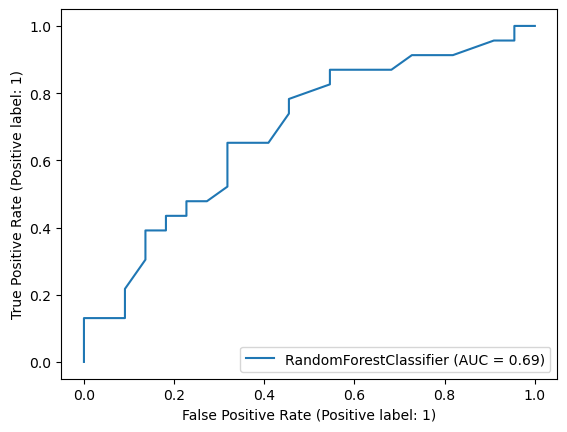

In [14]:
rf_disp = RocCurveDisplay.from_estimator(fitted_rf , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [15]:
cross_val_scores_acc = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.48888889 0.43181818 0.54545455 0.54545455 0.47727273]
Mean Accuracy:  0.49777777777777776
F1 Score for all folds:  [0.63492063 0.28571429 0.375      0.375      0.25806452]
Mean F1 Score:  0.3857398873527906
Precision for all folds:  [0.47619048 0.35714286 0.54545455 0.5        0.36363636]
Mean Precision:  0.44848484848484843
Recall for all folds:  [0.47619048 0.35714286 0.54545455 0.5        0.36363636]
Mean Recall:  0.44848484848484843


## XGBoost Classifier 

#### Train and Fit 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded, test_size=0.2)
xg_clf = xgboost.XGBClassifier()
fitted_xg = xg_clf.fit(X_train, y_train)
y_pred = xg_clf.predict(X_test)

# get accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')

Accuracy: 0.5777777777777777
Confusion Matrix:
[[17  7]
 [12  9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.64        24
           1       0.56      0.43      0.49        21

    accuracy                           0.58        45
   macro avg       0.57      0.57      0.56        45
weighted avg       0.58      0.58      0.57        45



#### ROC 

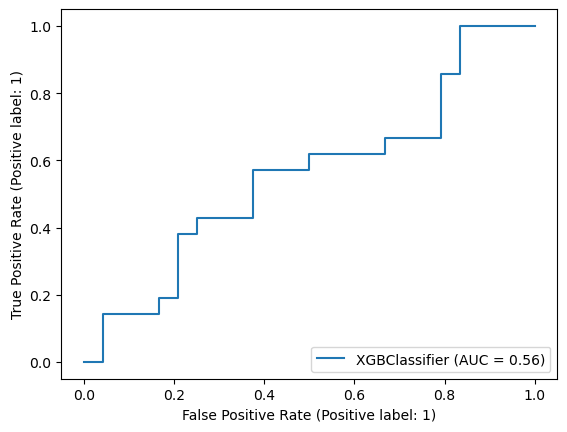

In [17]:
rf_disp = RocCurveDisplay.from_estimator(fitted_xg , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [18]:
cross_val_scores_acc = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.44444444 0.5        0.56818182 0.59090909 0.54545455]
Mean Accuracy:  0.5297979797979797
F1 Score for all folds:  [0.61538462 0.45       0.45714286 0.47058824 0.44444444]
Mean F1 Score:  0.48751203045320696
Precision for all folds:  [0.45454545 0.47368421 0.57142857 0.57142857 0.5       ]
Mean Precision:  0.5142173615857827
Recall for all folds:  [0.45454545 0.47368421 0.57142857 0.57142857 0.5       ]
Mean Recall:  0.5142173615857827


### Exploring Feature Importance in the XGBoost Classifier implementation using the SHAP library 

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

<Figure size 10000x480 with 0 Axes>

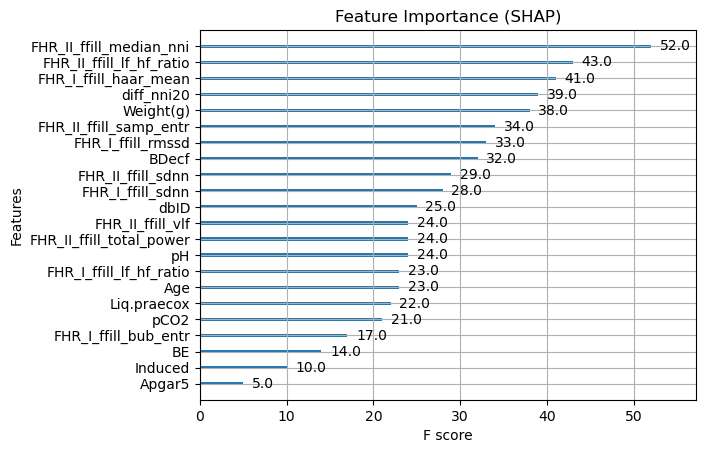

In [19]:
plt.figure().set_figwidth(100)
xgboost.plot_importance(xg_clf)

plt.title("Feature Importance (SHAP)")
plt.show()


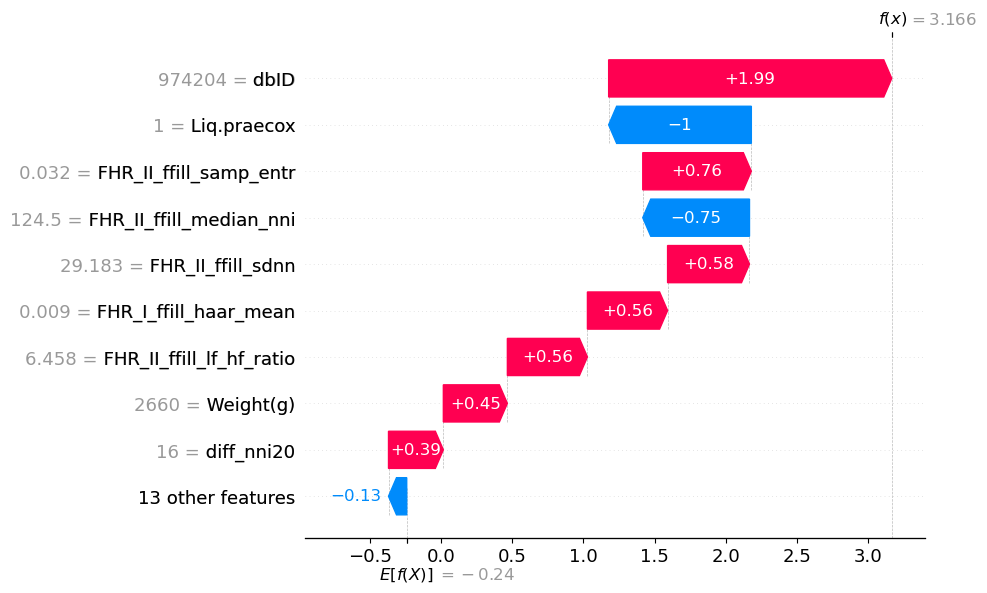

In [20]:
explainer = shap.Explainer(xg_clf, X_red_named)
shap_values = explainer(X_red_named)
shap.plots.waterfall(shap_values[0])